1. load input image and user edit prompt
2. operate VLM (Qwen to extract the parameters): id, class, bbox, matrix.
3. operate SAM to extract the binary mask
4. operate open-CV to to compute the shape mask.
5. operate SDL drawer with shape mask

# PART I - REASONING WITH VLMs

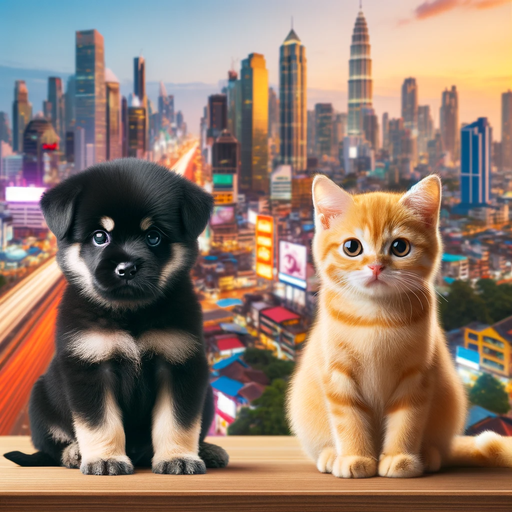

Text(value='', description='Edit Command:', placeholder='Enter your prompt here')

/dtu/blackhole/14/189044/marscho/cache/tmp/ipykernel_1189137/2576999861.py:36: DeprecationWarning: on_submit is deprecated. Instead, set the .continuous_update attribute to False and observe the value changing with: mywidget.observe(callback, 'value').
  user_prompt_widget.on_submit(print_user_prompt)


In [50]:

# Fixed image path
IMG_PATH = "/dtu/blackhole/14/189044/marscho/VLM_controller_for_SD/SLD-main_marco_latents/demo/image_editing/src_image/indoor_scene.png"

########################################################################################################################

# 1. load inputs (source image and user prompt)

import ipywidgets as widgets
from IPython.display import display, Image as IPImage
from PIL import Image


# Load the image using PIL
try:
    source_image = Image.open(IMG_PATH)
    # Display the image inline in the notebook
    display(IPImage(filename=IMG_PATH))
except FileNotFoundError:
    print("File not found. Please check the path and try again.")

# Create a text box widget for the user prompt
user_prompt_widget = widgets.Text(
    description='Edit Command:',
    placeholder='Enter your prompt here'
)

# Display the widget
display(user_prompt_widget)

# Function to print the user prompt
def print_user_prompt(change):
    user_prompt = user_prompt_widget.value
    print(f"User prompt: {user_prompt}")

# Attach the function to the user prompt widget to trigger on 'submit'
user_prompt_widget.on_submit(print_user_prompt)

### 1- Parsing Image Attributes (with VLM)

Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

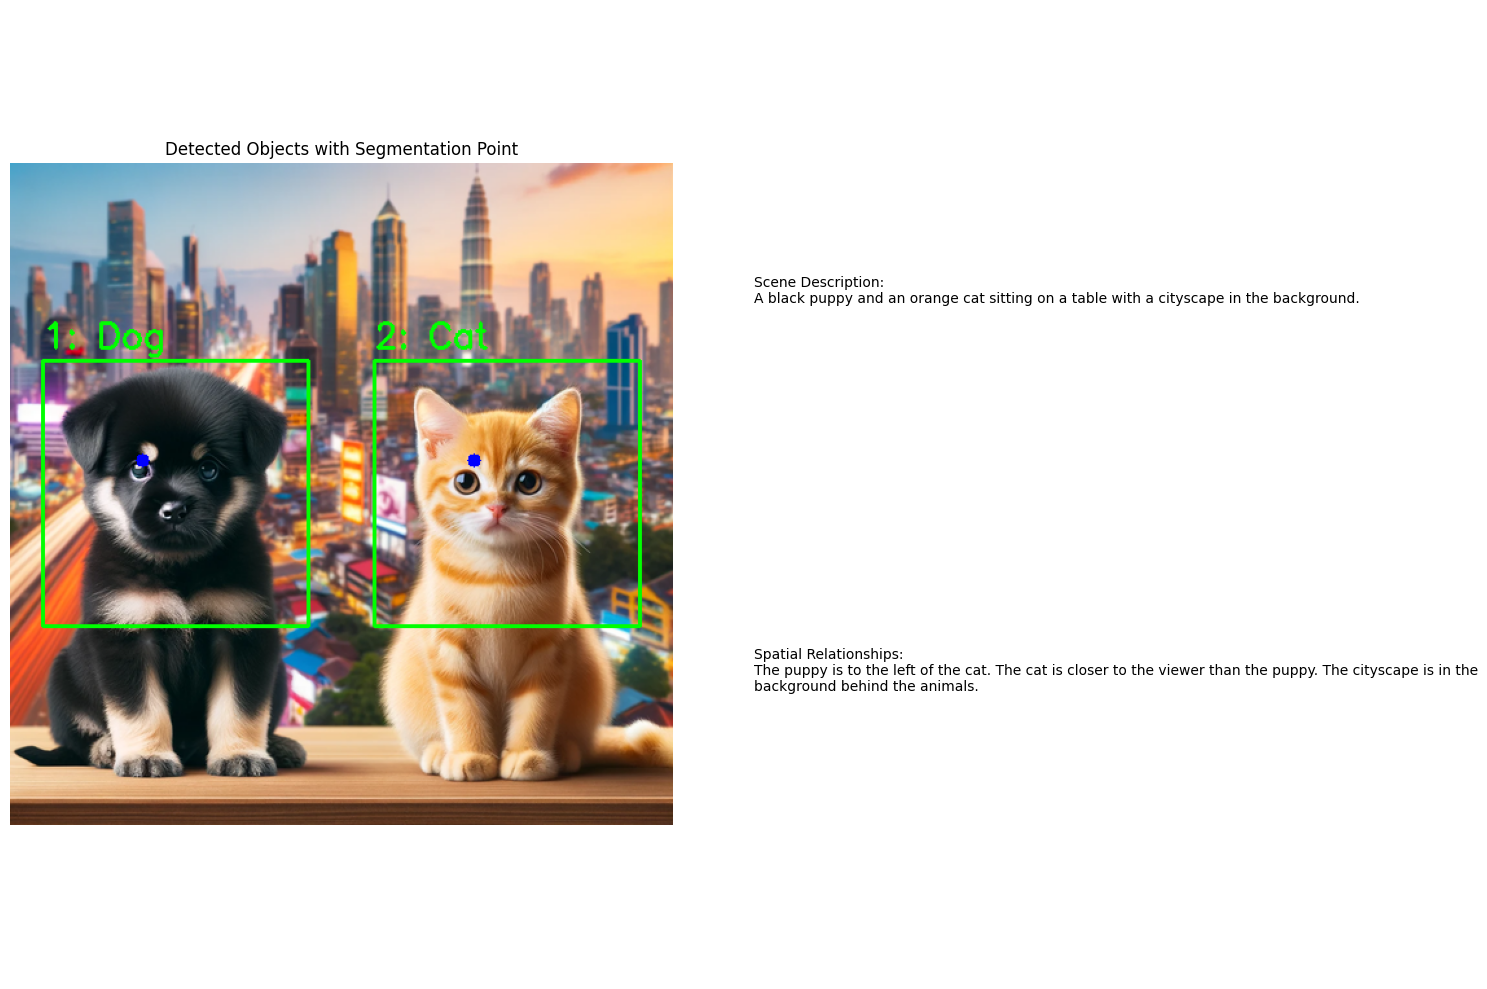


=== DETECTION RESULTS ===

Detected Objects:
Object 1:
  Class: Dog
  Bounding Box (normalized): xmin=0.050, ymin=0.300, xmax=0.450, ymax=0.700
  Segmentation Point: (0.200, 0.450)
Object 2:
  Class: Cat
  Bounding Box (normalized): xmin=0.550, ymin=0.300, xmax=0.950, ymax=0.700
  Segmentation Point: (0.700, 0.450)

Scene Description:
A black puppy and an orange cat sitting on a table with a cityscape in the background.

Spatial Relationships:
The puppy is to the left of the cat. The cat is closer to the viewer than the puppy. The cityscape is in the background behind the animals.



True

In [51]:
from transformers import Qwen2VLForConditionalGeneration, AutoTokenizer, AutoProcessor
from qwen_vl_utils import process_vision_info
import torch
import cv2
import matplotlib.pyplot as plt
import os
import re

if not os.path.exists(IMG_PATH):
    raise FileNotFoundError(f"Image file not found at {IMG_PATH}")

model = Qwen2VLForConditionalGeneration.from_pretrained(
    "Qwen/Qwen2-VL-7B-Instruct",
    torch_dtype=torch.bfloat16,
    device_map="auto",
)
processor = AutoProcessor.from_pretrained("Qwen/Qwen2-VL-7B-Instruct")

messages = [
    {
        "role": "system",
        "content": """You are a computer vision expert specializing in object detection, scene understanding and spatial relationships.
For each detected object in the image, output exactly one line in the following format:
DETECT: <object_id>|<object_class>|<xmin>|<ymin>|<xmax>|<ymax>

Then, for each object, identify one point that lies within the head or main focal part of the object in the format:
POINTS: <object_id>|<x>|<y>

Then, provide a scene analysis in the following format:
SCENE: <scene_description>

Finally, describe spatial relationships between objects:
SPATIAL: <spatial_relationships>

Where:
- <object_id> is a sequential number starting from 1
- <object_class> is the specific object category including attributes (color, size, etc)
- <xmin>,<ymin>,<xmax>,<ymax> are normalized coordinates (0-1) for the bounding box
- <x>,<y> are normalized coordinates (0-1) for a point that lies within the object's head/main part
- <scene_description> describes the overall context and setting
- <spatial_relationships> describes how objects relate to each other in space

Ensure the point is always within the head or main focal part of each object for accurate segmentation."""
    },
    {
        "role": "user",
        "content": [
            {
                "type": "image",
                "image": IMG_PATH
            },
            {
                "type": "text", 
                "text": "Analyze this image, detect the main objects, provide a point within the head/main part of each object for segmentation, describe the scene and spatial relationships between objects."
            }
        ]
    }
]

text = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
image_inputs, video_inputs = process_vision_info(messages)

inputs = processor(
    text=[text],
    images=image_inputs,
    videos=video_inputs,
    padding=True,
    return_tensors="pt",
).to("cuda")

generated_ids = model.generate(**inputs, max_new_tokens=256)
generated_ids_trimmed = [
    out_ids[len(in_ids):] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
]
output_text = processor.batch_decode(
    generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
)[0]

# Parse the detection and scene understanding output
def parse_model_output(output_text):
    objects = []  # Will store both bbox and point for each object
    scene_desc = ""
    spatial_rel = ""
    
    for line in output_text.split('\n'):
        line = line.strip()
        if line.startswith('DETECT:'):
            _, detection = line.split(':', 1)
            obj_id, obj_class, xmin, ymin, xmax, ymax = detection.strip().split('|')
            obj_id = int(obj_id)
            bbox = [float(xmin), float(ymin), float(xmax), float(ymax)]
            # Initialize object entry
            while len(objects) < obj_id:
                objects.append({'class': None, 'bbox': None, 'point': None})
            objects[obj_id-1]['class'] = obj_class
            objects[obj_id-1]['bbox'] = bbox
        elif line.startswith('POINTS:'):
            _, points_data = line.split(':', 1)
            obj_id, x, y = points_data.strip().split('|')
            obj_id = int(obj_id)
            point = (float(x), float(y))
            while len(objects) < obj_id:
                objects.append({'class': None, 'bbox': None, 'point': None})
            objects[obj_id-1]['point'] = point
        elif line.startswith('SCENE:'):
            _, scene_desc = line.split(':', 1)
        elif line.startswith('SPATIAL:'):
            _, spatial_rel = line.split(':', 1)
                
    return objects, scene_desc.strip(), spatial_rel.strip()

objects, scene_desc, spatial_rel = parse_model_output(output_text)

def annotate_image(image, objects):
    height, width = image.shape[:2]
    for i, obj in enumerate(objects):
        if obj['bbox']:
            # Draw bounding box
            xmin, ymin, xmax, ymax = [int(coord * width) if i % 2 == 0 else int(coord * height) 
                                    for i, coord in enumerate(obj['bbox'])]
            cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)
            cv2.putText(image, f"{i+1}: {obj['class']}", (xmin, ymin-10), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
        
        if obj['point']:
            # Draw point
            x, y = obj['point']
            px = int(x * width)
            py = int(y * height)
            cv2.circle(image, (px, py), 5, (255, 0, 0), -1)
    
    return image

image = cv2.imread(IMG_PATH)
plt.figure(figsize=(15, 10))

plt.subplot(1, 2, 1)
image = annotate_image(image, objects)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title("Detected Objects with Segmentation Point")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.text(0.1, 0.7, f"Scene Description:\n{scene_desc}", wrap=True)
plt.text(0.1, 0.3, f"Spatial Relationships:\n{spatial_rel}", wrap=True)
plt.axis('off')

plt.tight_layout()
plt.show()

# Create output directory if it doesn't exist
os.makedirs("output", exist_ok=True)

# Print and save results
print("\n=== DETECTION RESULTS ===")
print("\nDetected Objects:")
for i, obj in enumerate(objects):
    if obj['bbox'] is not None:
        print(f"Object {i+1}:")
        print(f"  Class: {obj['class']}")
        print(f"  Bounding Box (normalized): xmin={obj['bbox'][0]:.3f}, ymin={obj['bbox'][1]:.3f}, "
              f"xmax={obj['bbox'][2]:.3f}, ymax={obj['bbox'][3]:.3f}")
        if obj['point']:
            print(f"  Segmentation Point: ({obj['point'][0]:.3f}, {obj['point'][1]:.3f})")

print("\nScene Description:")
print(scene_desc)

print("\nSpatial Relationships:")
print(spatial_rel)
print("\n=====================")

img_name = IMG_PATH.split('/')[-1].split('.')[0]
output_file = f"output/{img_name}_detection.txt"

with open(output_file, 'w') as f:
    f.write("=== DETECTION RESULTS ===\n")
    f.write("\nDetected Objects:\n")
    for i, obj in enumerate(objects):
        if obj['bbox'] is not None:
            f.write(f"Object {i+1}:\n")
            f.write(f"  Class: {obj['class']}\n")
            f.write(f"  Bounding Box (normalized): xmin={obj['bbox'][0]:.3f}, ymin={obj['bbox'][1]:.3f}, "
                   f"xmax={obj['bbox'][2]:.3f}, ymax={obj['bbox'][3]:.3f}\n")
            if obj['point']:
                f.write(f"  Segmentation Point: ({obj['point'][0]:.3f}, {obj['point'][1]:.3f})\n")
    
    f.write("\nScene Description:\n")
    f.write(f"{scene_desc}\n")
    
    f.write("\nSpatial Relationships:\n") 
    f.write(f"{spatial_rel}\n")
    f.write("\n=====================\n")

# Save the annotated image
output_image_path = f"output/{img_name}_annotated.jpg"
cv2.imwrite(output_image_path, cv2.cvtColor(image, cv2.COLOR_RGB2BGR))


### 2 - SAM gets binary mask

In [52]:
IN_FILE_DESCRIPTION = "/dtu/blackhole/14/189044/marscho/VLM_controller_for_SD/output/indoor_scene_detection.txt"   
img_name = "indoor_scene"

"""
input: FILE_DESCRIPTION, IMG_PATH
output: masks (segmentation, and binary)

Note: The enhanced detection results file will now use the SAM-generated bounding boxes
for each detected object.
"""

########################################################################################################################


import torch
from sam2.sam2_image_predictor import SAM2ImagePredictor
import numpy as np
from ultralytics import SAM
import matplotlib.pyplot as plt
import cv2
import os
import re

# Create output directory if it doesn't exist
output_dir = 'output'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)


# Parse bounding box coordinates from detection file
with open(IN_FILE_DESCRIPTION, 'r') as f:
    content = f.read()

# Get image dimensions
img = cv2.imread(IMG_PATH)
img_height, img_width = img.shape[:2]

# Extract bounding box coordinates and segmentation points for each object
objects = []
# Use regex to find all object blocks
object_blocks = re.findall(r'Object \d+:(.*?)(?=Object \d+:|$)', content, re.DOTALL)

for obj_block in object_blocks:
    # Extract class name
    class_match = re.search(r'Class:\s*(\w+)', obj_block)
    if class_match:
        class_name = class_match.group(1).strip()
        
        # Extract bounding box coordinates
        bbox_match = re.search(r'Bounding Box \(normalized\):\s*xmin=([\d.]+),\s*ymin=([\d.]+),\s*xmax=([\d.]+),\s*ymax=([\d.]+)', obj_block)
        if bbox_match:
            xmin, ymin, xmax, ymax = map(float, bbox_match.groups())
            
            # Extract segmentation points
            seg_points = []
            if 'Segmentation Point:' in obj_block:
                point_match = re.search(r'\(([\d.]+),\s*([\d.]+)\)', obj_block)
                if point_match:
                    x, y = map(float, point_match.groups())
                    seg_points.append([x * img_width, y * img_height])
            
            # Calculate center point and scale to image dimensions
            center_x = (xmin + xmax) / 2 * img_width
            center_y = (ymin + ymax) / 2 * img_height
            
            # Make bbox 30% bigger
            width = (xmax - xmin) * img_width
            height = (ymax - ymin) * img_height
            
            # Expand by 30% in each direction
            xmin = max(0, xmin * img_width - width * 0.15)
            ymin = max(0, ymin * img_height - height * 0.15)
            xmax = min(img_width, xmax * img_width + width * 0.15)
            ymax = min(img_height, ymax * img_height + height * 0.15)
            
            # Store center, bbox coordinates and segmentation points
            objects.append({
                'class': class_name,
                'center': [center_x, center_y],
                'bbox': [xmin, ymin, xmax, ymax],
                'seg_points': seg_points
            })

# Convert to input format for SAM
input_points = np.array([[obj['center'][0], obj['center'][1]] for obj in objects])
input_labels = np.array([1] * len(objects))  # 1 indicates foreground point
input_boxes = np.array([[obj['bbox'][0], obj['bbox'][1], obj['bbox'][2], obj['bbox'][3]] for obj in objects])

# Add segmentation points to input points and labels
for obj in objects:
    if obj['seg_points']:
        seg_points = np.array(obj['seg_points'])
        input_points = np.vstack([input_points, seg_points])
        input_labels = np.append(input_labels, [1] * len(obj['seg_points']))

print("Using points and bbox prompts together:")
print("Points:", input_points)
print("Labels:", input_labels)
print("Boxes:", input_boxes)

# Load a model
model = SAM("sam2.1_b.pt")

# Display model information (optional)
model.info()

# Run inference with both points and bounding box prompts
results = model(IMG_PATH, points=input_points.tolist(), labels=input_labels.tolist())

# Store SAM bboxes for each object
sam_bboxes = {}

# Plot and save the results for each object
for i, (r, obj) in enumerate(zip(results, objects)):
    print(f"Processing object {i+1}: {obj['class']}")  # Debug print
    
    # Create figure with 3 subplots side by side
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Get segmentation result and binary mask
    im_array = r.plot()  # Segmentation result
    im_array = im_array[:, :, ::-1]  # Convert BGR to RGB
    
    # Check if there are any masks
    if len(r.masks.data) == 0:
        print(f"Warning: No mask found for {obj['class']}")
        continue
        
    mask_array = r.masks.data[0].cpu().numpy()  # Binary mask
    
    # Get bounding box of binary mask
    rows = np.any(mask_array, axis=1)
    cols = np.any(mask_array, axis=0)
    
    # Check if mask is empty
    if not np.any(rows) or not np.any(cols):
        print(f"Warning: Empty mask for {obj['class']}")
        continue
        
    ymin, ymax = np.where(rows)[0][[0, -1]]
    xmin, xmax = np.where(cols)[0][[0, -1]]
    
    # 1. Original image with segmentation
    axes[0].imshow(im_array)
    axes[0].set_title(f"{obj['class']} - Segmented Image")
    axes[0].axis('off')
    
    # 2. Binary mask
    axes[1].imshow(mask_array, cmap='gray')
    axes[1].set_title(f"{obj['class']} - Binary Mask")
    axes[1].axis('off')
    
    # 3. Binary mask with bounding box
    axes[2].imshow(mask_array, cmap='gray')
    rect = plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, 
                        fill=False, edgecolor='red', linewidth=2)
    axes[2].add_patch(rect)
    axes[2].set_title(f"{obj['class']} - Mask with Bounding Box")
    axes[2].axis('off')
    
    plt.tight_layout()
    
    # Save the figure
    output_path = os.path.join(output_dir, f'{obj["class"]}_analysis_{i}.png')
    plt.savefig(output_path)
    print(f"Saved analysis plot to: {output_path}")
    plt.close()
    
    # Save individual components
    plt.imsave(os.path.join(output_dir, f'{obj["class"]}_segmentation_{i}.png'), im_array)
    plt.imsave(os.path.join(output_dir, f'{obj["class"]}_binary_mask_{i}.png'), mask_array, cmap='gray')
    
    # Calculate and store normalized bbox coordinates
    mask_bbox = {
        'xmin': float(xmin) / mask_array.shape[1],
        'ymin': float(ymin) / mask_array.shape[0],
        'xmax': float(xmax) / mask_array.shape[1],
        'ymax': float(ymax) / mask_array.shape[0]
    }
    
    # Store SAM bbox for this object
    sam_bboxes[obj["class"]] = mask_bbox
    
    # Save mask bbox to file
    stringa = "SAM"
    mask_bbox_file = os.path.join(output_dir, f'{stringa + obj["class"]}_mask_bbox_{i}.txt')
    with open(mask_bbox_file, 'w') as f:
        f.write(f"Mask Bounding Box (normalized):\n")
        f.write(f"xmin={mask_bbox['xmin']:.3f}, ymin={mask_bbox['ymin']:.3f}, ")
        f.write(f"xmax={mask_bbox['xmax']:.3f}, ymax={mask_bbox['ymax']:.3f}\n")
        # Add SLD format
        width = mask_bbox['xmax'] - mask_bbox['xmin']
        height = mask_bbox['ymax'] - mask_bbox['ymin']
        f.write(f"\nBounding Box (SLD format):\n")
        f.write(f"[{mask_bbox['xmin']:.3f}, {mask_bbox['ymin']:.3f}, {width:.3f}, {height:.3f}]\n")

# Save the enhanced detection results to a file (now using SAM bboxes)
enhanced_detection_file = os.path.join(output_dir, f"{img_name}_detection_enhanced.txt")
with open(enhanced_detection_file, 'w') as f:
    f.write("=== ENHANCED DETECTION RESULTS ===\n")
    f.write("\nDetected Objects:\n")
    for i, obj in enumerate(objects):
        f.write(f"Object {i+1}:\n")
        f.write(f"  Class: {obj['class']}\n")
        # Use SAM bbox for this object if available, otherwise use original bbox
        if obj['class'] in sam_bboxes:
            sam_bbox = sam_bboxes[obj['class']]
            f.write(f"  Bounding Box (normalized): xmin={sam_bbox['xmin']:.3f}, ymin={sam_bbox['ymin']:.3f}, "
                   f"xmax={sam_bbox['xmax']:.3f}, ymax={sam_bbox['ymax']:.3f}\n")
        else:
            # Convert original bbox back to normalized coordinates
            orig_bbox = obj['bbox']
            f.write(f"  Bounding Box (normalized): xmin={orig_bbox[0]/img_width:.3f}, ymin={orig_bbox[1]/img_height:.3f}, "
                   f"xmax={orig_bbox[2]/img_width:.3f}, ymax={orig_bbox[3]/img_height:.3f}\n")
            
        if obj['seg_points']:
            f.write(f"  Segmentation Points:\n")
            for point in obj['seg_points']:
                f.write(f"    ({point[0]/img_width:.3f}, {point[1]/img_height:.3f})\n")
    
    # Extract scene description and spatial relationships from original file
    scene_desc_match = re.search(r'Scene Description:\n(.*?)\n', content)
    spatial_rel_match = re.search(r'Spatial Relationships:\n(.*?)(?=\n=+|$)', content, re.DOTALL)
    
    scene_desc = scene_desc_match.group(1) if scene_desc_match else ""
    spatial_rel = spatial_rel_match.group(1).strip() if spatial_rel_match else ""
    
    f.write("\nScene Description:\n")
    f.write(f"{scene_desc}\n")
    
    f.write("\nSpatial Relationships:\n") 
    f.write(f"{spatial_rel}\n")
    f.write("\n=====================\n")


Using points and bbox prompts together:
Points: [[        128         256]
 [        384         256]
 [      102.4       230.4]
 [      358.4       230.4]]
Labels: [1 1 1 1]
Boxes: [[          0      122.88      261.12      389.12]
 [     250.88      122.88         512      389.12]]
Model summary: 566 layers, 80,850,178 parameters, 80,850,178 gradients

image 1/1 /dtu/blackhole/14/189044/marscho/VLM_controller_for_SD/SLD-main_marco_latents/demo/image_editing/src_image/indoor_scene.png: 1024x1024 1 0, 1 1, 1 2, 1 3, 43.6ms
Speed: 3.4ms preprocess, 43.6ms inference, 0.5ms postprocess per image at shape (1, 3, 1024, 1024)
Processing object 1: Dog
Saved analysis plot to: output/Dog_analysis_0.png


### 3 - QWEN Math

In [62]:
import re
import numpy as np
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch

FILE_DESCRIPTION = "output/indoor_scene_detection_enhanced.txt"

# Example user edits with clear descriptions
# USER_EDIT = "Scale the object to be twice as large"  # Current active transformation
# USER_EDIT = "Move the object upward by 100 pixels."
# USER_EDIT = "Rotate by 45 degrees clockwise."
USER_EDIT = "Rescale the dog's height to be 12% smaller"
# USER_EDIT = "Move the object diagonally up and left by 100 pixels each"
# USER_EDIT = "Move the object left by 100 pixels and rotate it by 90 degrees clockwise."

def parse_detection_file(file_path):
    """Parse detection file and extract object information."""
    with open(file_path, 'r') as f:
        detection_data = f.read()

    # Extract scene description and spatial relationships
    scene_desc_match = re.search(r'Scene Description:\n(.*?)\n', detection_data)
    spatial_rel_match = re.search(r'Spatial Relationships:\n(.*?)\n', detection_data)
    
    scene_desc = scene_desc_match.group(1) if scene_desc_match else ""
    spatial_rel = spatial_rel_match.group(1) if spatial_rel_match else ""

    objects = []
    pattern = r'Object (\d+):\n\s+Class: (.*?)\n\s+Bounding Box.*?xmin=([\d.]+), ymin=([\d.]+), xmax=([\d.]+), ymax=([\d.]+)'
    
    for match in re.finditer(pattern, detection_data):
        xmin, ymin, xmax, ymax = map(float, match.groups()[2:])
        
        corners = np.array([
            [xmin, ymin, 1],  # top-left
            [xmax, ymin, 1],  # top-right
            [xmax, ymax, 1],  # bottom-right
            [xmin, ymax, 1]   # bottom-left
        ])
        
        obj = {
            'id': int(match.group(1)),
            'class': match.group(2),
            'bbox': [xmin, ymin, xmax, ymax],
            'corners': corners,
            'width': xmax - xmin,
            'height': ymax - ymin,
            'center': [(xmax + xmin)/2, (ymax + ymin)/2]
        }
        objects.append(obj)
    
    return objects, scene_desc, spatial_rel

# Define transformation matrices with clear mathematical formulas
class TransformationMatrices:
    @staticmethod
    def translation(tx, ty):
        return np.array([[1, 0, tx],
                        [0, 1, ty],
                        [0, 0, 1]])
    
    @staticmethod
    def rotation(theta):
        return np.array([[np.cos(theta), -np.sin(theta), 0],
                        [np.sin(theta), np.cos(theta), 0],
                        [0, 0, 1]])
    
    @staticmethod
    def scaling(sx, sy):
        return np.array([[sx, 0, 0],
                        [0, sy, 0],
                        [0, 0, 1]])
    
    @staticmethod
    def shear(shx, shy):
        return np.array([[1, shx, 0],
                        [shy, 1, 0],
                        [0, 0, 1]])

def setup_model():
    """Initialize the language model for transformation reasoning."""
    model_name = "Qwen/Qwen2.5-Math-7B-Instruct"
    device = "cuda"
    
    model = AutoModelForCausalLM.from_pretrained(
        model_name,
        torch_dtype=torch.bfloat16,
        device_map="cuda",
    )
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    
    return model, tokenizer

def get_transformation_matrix(model, tokenizer, user_edit, objects, scene_desc, spatial_rel):
    """Get transformation matrix from model reasoning."""
    # Create context from scene information
    scene_context = f"""Scene Information:
    {scene_desc}
    
    Spatial Relationships:
    {spatial_rel}
    
    Object Dimensions:"""
    
    for obj in objects:
        scene_context += f"""
    {obj['class']}:
        Width: {obj['width']:.3f}
        Height: {obj['height']:.3f}
        Center: ({obj['center'][0]:.3f}, {obj['center'][1]:.3f})"""

    messages = [
        {"role": "system", "content": "Integrate natural language reasoning with programs to solve user query. Given the context information and object dimensions below, determine the appropriate transformation matrix for the requested edit.\n\n""
                                    "Scene content: " + scene_context + "\n\n"
                                    "List of possible operations:\n"
                                    "1. Translation: Moving objects in x,y directions\n"
                                    "   Example: [[1 0 tx][0 1 ty][0 0 1]]\n\n"
                                    "2. Rotation: Rotating objects by angle θ\n"
                                    "   Example: [[cos(θ) -sin(θ) 0][sin(θ) cos(θ) 0][0 0 1]]\n\n"
                                    "3. Scaling: Changing object size\n"
                                    "   Example: [[sx 0 0][0 sy 0][0 0 1]]\n\n"
                                    "4. Shear: Skewing objects\n"
                                    "   Example: [[1 shx 0][shy 1 0][0 0 1]]\n\n"
                                    "5. Combined transformations are also allowed:\n"
                                    "   Example: Translation + Rotation = [[cos(θ) -sin(θ) tx][sin(θ) cos(θ) ty][0 0 1]]\n\n"   
                                    
        },
        {"role": "user", "content": user_edit}
    ]
    text = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    model_inputs = tokenizer([text], return_tensors="pt").to("cuda")
    
    generated_ids = model.generate(
        **model_inputs,
        max_new_tokens=1024
    )
    generated_ids = [output_ids[len(input_ids):] for input_ids, output_ids in zip(model_inputs.input_ids, generated_ids)]
    
    reasoning = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]
    
    print("\n=== Model Reasoning ===")
    print(reasoning)
    print("\n=====================")
    
    return parse_matrix_from_reasoning(reasoning)

def parse_matrix_from_reasoning(reasoning):
    """Extract and parse transformation matrix from model reasoning."""
    # Look for matrix pattern in the output format, including LaTeX style matrices
    # Find the output marker first
    output_start = reasoning.find("```output")
    if output_start == -1:
        raise ValueError("Could not find output section in model reasoning")
    
    # Search for matrix patterns after the output marker
    reasoning_after_output = reasoning[output_start:]
    
    matrix_patterns = [
        # Standard array format
        r'\[\s*\[\s*([-+]?\d*\.?\d+)\s*,\s*([-+]?\d*\.?\d+)\s*,\s*([-+]?\d*\.?\d+)\s*\]'
        r'\s*,\s*\[\s*([-+]?\d*\.?\d+)\s*,\s*([-+]?\d*\.?\d+)\s*,\s*([-+]?\d*\.?\d+)\s*\]'
        r'\s*,\s*\[\s*([-+]?\d*\.?\d+)\s*,\s*([-+]?\d*\.?\d+)\s*,\s*([-+]?\d*\.?\d+)\s*\]\s*\]',
        
        # LaTeX style matrix pattern
        r'\\begin{pmatrix}\s*([-+]?\d*\.?\d+/?\d*)\s*&\s*([-+]?\d*\.?\d+/?\d*)\s*&\s*([-+]?\d*\.?\d+/?\d*)\s*\\\\'
        r'\s*([-+]?\d*\.?\d+/?\d*)\s*&\s*([-+]?\d*\.?\d+/?\d*)\s*&\s*([-+]?\d*\.?\d+/?\d*)\s*\\\\'
        r'\s*([-+]?\d*\.?\d+/?\d*)\s*&\s*([-+]?\d*\.?\d+/?\d*)\s*&\s*([-+]?\d*\.?\d+/?\d*)\s*\\end{pmatrix}'
    ]
    
    matrix_values = None
    for pattern in matrix_patterns:
        match = re.search(pattern, reasoning_after_output)
        if match:
            matrix_values = match.groups()
            break
    
    if not matrix_values:
        raise ValueError("Could not find transformation matrix in model output section")
    
    # Convert fractions (like sqrt(2)/2) to decimal numbers
    def convert_fraction(s):
        if '/' in s:
            if 'sqrt(2)' in s or '\\sqrt{2}' in s:
                return np.sqrt(2)/2
            num, denom = s.split('/')
            return float(num) / float(denom)
        return float(s)
    
    # Convert all values to floats
    matrix = np.array([convert_fraction(val) for val in matrix_values]).reshape(3, 3)
    
    return matrix

def main():
    # Parse detection file with enhanced information
    objects, scene_desc, spatial_rel = parse_detection_file(FILE_DESCRIPTION)
    
    # Setup model
    model, tokenizer = setup_model()
    
    # Get transformation matrix with scene context
    matrix_array = get_transformation_matrix(model, tokenizer, USER_EDIT, objects, scene_desc, spatial_rel)
    
    print("Parsed Matrix:")
    print(matrix_array)
    
    # Store transformation matrix to file
    TRANSFORMATION_MATRIX_FILE = f'output/{img_name}_transformation_matrix.npy'
    np.save(TRANSFORMATION_MATRIX_FILE, matrix_array)
    print(f"Transformation matrix saved to {TRANSFORMATION_MATRIX_FILE}")
    
    return matrix_array

# Execute main function
if __name__ == "__main__":
    matrix_array = main()


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]


=== Model Reasoning ===
To solve the problem of rescaling the dog's height to be 12% smaller, we need to apply a scaling transformation to the dog's height. The scaling factor for the height will be \(1 - 0.12 = 0.88\). The width of the dog will remain unchanged.

The initial dimensions of the dog are:
- Width: 0.382
- Height: 0.613
- Center: (0.250, 0.618)

The scaling transformation matrix for scaling the height by 0.88 is:
\[
\begin{pmatrix}
1 & 0 & 0 \\
0 & 0.88 & 0 \\
0 & 0 & 1
\end{pmatrix}
\]

We will apply this transformation matrix to the center of the dog. The new center of the dog after scaling will be:
\[
\begin{pmatrix}
1 & 0 & 0 \\
0 & 0.88 & 0 \\
0 & 0 & 1
\end{pmatrix}
\begin{pmatrix}
0.250 \\
0.618 \\
1
\end{pmatrix}
=
\begin{pmatrix}
0.250 \\
0.54424 \\
1
\end{pmatrix}
\]

The new dimensions of the dog will be:
- Width: 0.382 (unchanged)
- Height: \(0.613 \times 0.88 = 0.54424\)
- Center: (0.250, 0.54424)

Let's implement this in Python to confirm the result.
```pyth

### Open CV Mask Transformation


Loaded transformation matrix:
[[          1           0           0]
 [          0      0.7744      33.143]
 [          0           0           1]]

Mask transformation matrix (y-scaling and translation inverted):
[[          1           0           0]
 [          0      1.2913     -33.143]
 [          0           0           1]]

Binary Mask Shape: (512, 512)

Transformed Bounding Box (normalized):
xmin=0.059, ymin=0.445, xmax=0.441, ymax=0.920

Transformed Bounding Box (SLD format):
[0.059, 0.445, 0.382, 0.475]

Transformed bbox saved to: output/indoor_scene_transformed_bbox.txt

Transformed mask saved to: output/indoor_scene_transformed_mask.png

Original mask saved to: output/indoor_scene_source_mask.npy
Transformed mask saved to: output/indoor_scene_target_mask.npy


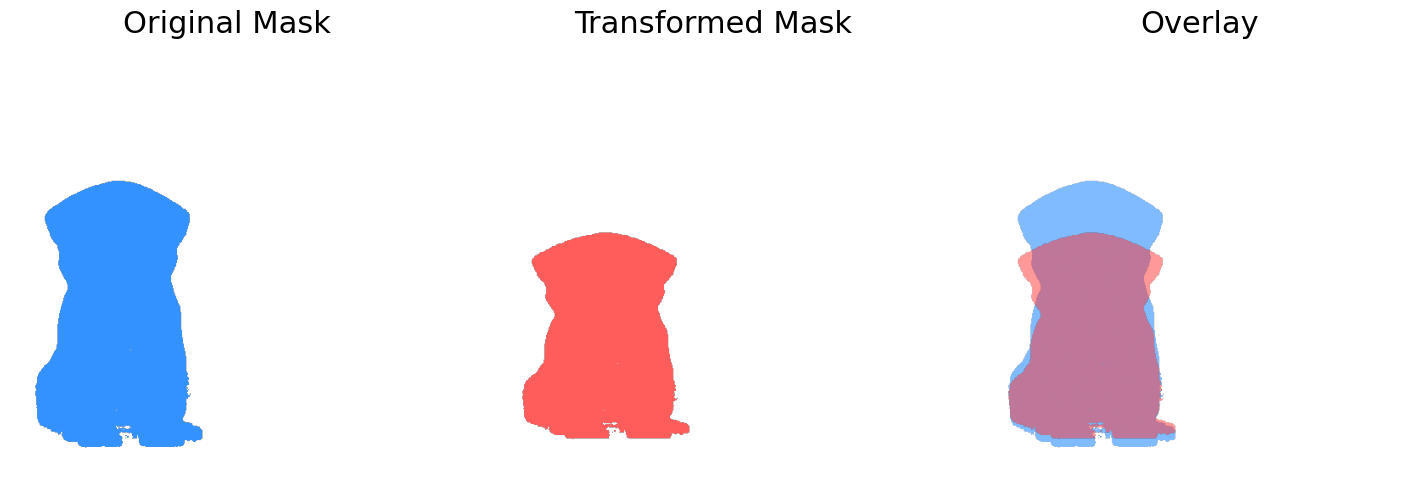

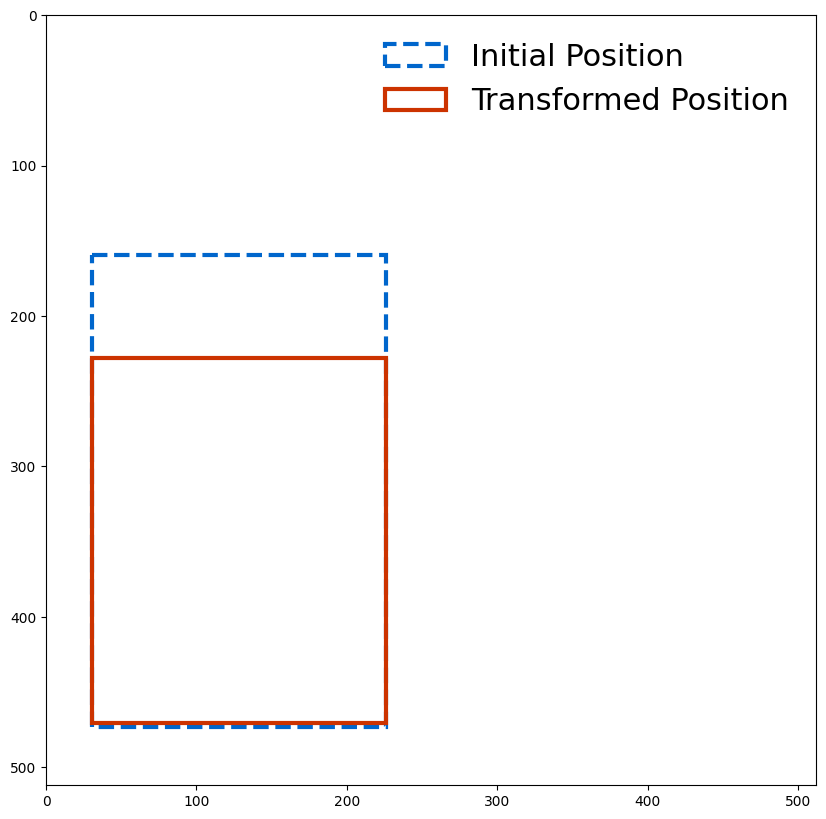

In [73]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt

def process_transformation_matrix_top_left(matrix, scaling_factor_y, bbox_ymin, bbox_height):
    """
    Process a transformation matrix to include scaling with feet grounding
    (assuming top-left origin).

    Parameters:
        matrix (np.array): The original transformation matrix.
        scaling_factor_y (float): The scaling factor in the Y-axis.
        bbox_ymin (float): The ymin (top) of the bounding box in pixels.
        bbox_height (float): The height of the bounding box in pixels.

    Returns:
        np.array: The adjusted transformation matrix.
    """
    # Original height and scaled height
    original_height = bbox_height
    new_height = scaling_factor_y * original_height

    # Bottom (ymax) position remains fixed
    bbox_ymax = bbox_ymin + original_height
    new_bbox_ymin = bbox_ymax - new_height  # Adjust ymin to keep ymax fixed

    # Translation correction to shift ymin
    translation_correction = new_bbox_ymin - bbox_ymin

    # Create a scaling and translation matrix
    scaling_translation_matrix = np.array([
        [1, 0, 0],                           # X-axis scaling remains unchanged
        [0, scaling_factor_y, translation_correction],  # Apply scaling and translation in Y-axis
        [0, 0, 1]
    ], dtype=np.float32)

    # Combine the original matrix with the new scaling and translation matrix
    adjusted_matrix = matrix @ scaling_translation_matrix
    return adjusted_matrix

# Constants
img_name = "indoor_scene"
output_dir = 'output'
MASK_FILE_NAME = "Dog_binary_mask_0.png"
ENHANCED_FILE_DESCRIPTION = "output/indoor_scene_detection_enhanced.txt"

# Load and validate transformation matrix
try:
    # Create initial transformation matrix
    loaded_matrix = np.array([[1, 0, 0],
                             [0, 0.88, 0],  # Original scaling factor
                             [0, 0, 1]], dtype=np.float32)
    
    # Load and validate binary mask
    mask_path = os.path.join(output_dir, MASK_FILE_NAME)
    binary_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    
    if binary_mask is None:
        raise FileNotFoundError(f"Could not load binary mask from {mask_path}")
    
    height, width = binary_mask.shape
    
    # Read object boundaries from detection file
    with open(ENHANCED_FILE_DESCRIPTION, 'r') as f:
        detection_text = f.read()

    # Extract bounding box coordinates
    bbox_line = [line for line in detection_text.split('\n') if 'Bounding Box' in line][0]
    ymin = float(bbox_line.split('ymin=')[1].split(',')[0])
    bbox_height = height * (float(bbox_line.split('ymax=')[1].split(')')[0]) - ymin)
    ymin = ymin * height

    # Process the transformation matrix to keep feet grounded
    loaded_matrix = process_transformation_matrix_top_left(loaded_matrix, 0.88, ymin, bbox_height)
    
    # Create mask transformation matrix by inverting y-scaling and y-translation
    mask_matrix = loaded_matrix.copy()
    mask_matrix[1,1] = 1/loaded_matrix[1,1]  # Invert y-scaling
    mask_matrix[1,2] = -loaded_matrix[1,2]   # Invert y-translation
    
    print("Loaded transformation matrix:")
    print(loaded_matrix)
    print("\nMask transformation matrix (y-scaling and translation inverted):")
    print(mask_matrix)
    
except FileNotFoundError:
    raise FileNotFoundError(f"Could not load transformation matrix from {TRANSFORMATION_MATRIX_FILE}")

print("\nBinary Mask Shape:", binary_mask.shape)

# Get mask dimensions
height, width = binary_mask.shape

# Read object boundaries from detection file
with open(ENHANCED_FILE_DESCRIPTION, 'r') as f:
    detection_text = f.read()

# Extract bounding box coordinates
bbox_line = [line for line in detection_text.split('\n') if 'Bounding Box' in line][0]
xmin = float(bbox_line.split('xmin=')[1].split(',')[0])
ymin = float(bbox_line.split('ymin=')[1].split(',')[0])
xmax = float(bbox_line.split('xmax=')[1].split(',')[0])
ymax = float(bbox_line.split('ymax=')[1].split(')')[0])

# Convert normalized coordinates to pixel coordinates
x_min = int(xmin * width)
x_max = int(xmax * width)
y_min = int(ymin * height)
y_max = int(ymax * height)

# Calculate object center
x_center = (x_min + x_max) // 2
y_center = (y_min + y_max) // 2

# Create translation matrices for centering
# Note: We flip the y-translation since image coordinates have origin at top-left
T_to_origin = np.array([
    [1, 0, -x_center],
    [0, 1, -y_center],
    [0, 0, 1]
])

T_from_origin = np.array([
    [1, 0, x_center],
    [0, 1, y_center],
    [0, 0, 1]
])

# Compose final transformation with inverted y-scaling for mask
final_transform = T_from_origin @ mask_matrix @ T_to_origin

# Generate coordinate grid
y, x = np.mgrid[0:height, 0:width]
coords = np.stack((x.flatten(), y.flatten(), np.ones_like(x.flatten())), axis=1).T

# Apply transformation to coordinates
transformed_coords = final_transform @ coords
transformed_coords /= transformed_coords[2]  # Normalize homogeneous coordinates

# Reshape back to image dimensions
transformed_x = transformed_coords[0].reshape(height, width)
transformed_y = transformed_coords[1].reshape(height, width)

# Remap the mask using transformed coordinates
transformed_mask = cv2.remap(binary_mask,
                           transformed_x.astype(np.float32),
                           transformed_y.astype(np.float32),
                           interpolation=cv2.INTER_NEAREST,
                           borderMode=cv2.BORDER_CONSTANT,
                           borderValue=0)

# Transform bbox from enhanced detection file
with open(ENHANCED_FILE_DESCRIPTION, 'r') as f:
    enhanced_text = f.read()

# Extract enhanced bounding box coordinates
enhanced_bbox_line = [line for line in enhanced_text.split('\n') if 'Bounding Box' in line][0]
enhanced_xmin = float(enhanced_bbox_line.split('xmin=')[1].split(',')[0])
enhanced_ymin = float(enhanced_bbox_line.split('ymin=')[1].split(',')[0])
enhanced_xmax = float(enhanced_bbox_line.split('xmax=')[1].split(',')[0])
enhanced_ymax = float(enhanced_bbox_line.split('ymax=')[1].split(',')[0])

# Convert normalized coordinates to pixel coordinates
bbox_coords = np.array([
    [enhanced_xmin * width, enhanced_ymin * height, 1],
    [enhanced_xmax * width, enhanced_ymin * height, 1],
    [enhanced_xmax * width, enhanced_ymax * height, 1],
    [enhanced_xmin * width, enhanced_ymax * height, 1]
]).T

# Transform bbox coordinates with original transformation (not inverted)
transformed_bbox = T_from_origin @ loaded_matrix @ T_to_origin @ bbox_coords
transformed_bbox /= transformed_bbox[2]  # Normalize homogeneous coordinates

# Convert back to normalized coordinates
transformed_bbox_normalized = np.array([
    transformed_bbox[0] / width,
    transformed_bbox[1] / height
])

# Print transformed bbox to console in both formats
print("\nTransformed Bounding Box (normalized):")
print(f"xmin={transformed_bbox_normalized[0,0]:.3f}, "
      f"ymin={transformed_bbox_normalized[1,0]:.3f}, "
      f"xmax={transformed_bbox_normalized[0,1]:.3f}, "
      f"ymax={transformed_bbox_normalized[1,2]:.3f}")

# Convert to SLD format [Top-left x, Top-left y, Width, Height]
sld_x = transformed_bbox_normalized[0,0]
sld_y = transformed_bbox_normalized[1,0]
sld_width = transformed_bbox_normalized[0,1] - transformed_bbox_normalized[0,0]
sld_height = transformed_bbox_normalized[1,2] - transformed_bbox_normalized[1,0]

print("\nTransformed Bounding Box (SLD format):")
print(f"[{sld_x:.3f}, {sld_y:.3f}, {sld_width:.3f}, {sld_height:.3f}]")

# Save transformed bbox to file (both formats)
transformed_bbox_file = f'output/{img_name}_transformed_bbox.txt'
with open(transformed_bbox_file, 'w') as f:
    f.write("Transformed Bounding Box (normalized):\n")
    f.write(f"xmin={transformed_bbox_normalized[0,0]:.3f}, ")
    f.write(f"ymin={transformed_bbox_normalized[1,0]:.3f}, ")
    f.write(f"xmax={transformed_bbox_normalized[0,1]:.3f}, ")
    f.write(f"ymax={transformed_bbox_normalized[1,2]:.3f}\n")
    f.write("\nTransformed Bounding Box (SLD format):\n")
    f.write(f"[{sld_x:.3f}, {sld_y:.3f}, {sld_width:.3f}, {sld_height:.3f}]\n")

print(f"\nTransformed bbox saved to: {transformed_bbox_file}")

# Save the transformed mask
output_mask_path = f'output/{img_name}_transformed_mask.png'
cv2.imwrite(output_mask_path, transformed_mask)
print(f"\nTransformed mask saved to: {output_mask_path}")

# Save the original and transformed masks as .npy files
source_mask_path = f'output/{img_name}_source_mask.npy'
target_mask_path = f'output/{img_name}_target_mask.npy'
np.save(source_mask_path, binary_mask)
np.save(target_mask_path, transformed_mask)
print(f"\nOriginal mask saved to: {source_mask_path}")
print(f"Transformed mask saved to: {target_mask_path}")
# Visualization - Mask Transformation
plt.figure(figsize=(15, 5))

# Create subplots for better comparison
plt.subplot(131)
# Original mask visualization
plt.imshow(np.zeros((height, width, 3), dtype=np.uint8) + 255)  # White background
mask_overlay = np.zeros((height, width, 4))
mask_overlay[binary_mask > 0] = [0, 0.47, 1, 0.8]  # Professional blue with alpha
plt.imshow(mask_overlay)
plt.title('Original Mask', fontsize=22, pad=10)  # Increased from 14
# plt.plot([0, width-1, width-1, 0, 0], [0, 0, height-1, height-1, 0], 'k-', linewidth=1)  # Add corners
plt.axis('off')

plt.subplot(132) 
# Transformed mask visualization
plt.imshow(np.zeros((height, width, 3), dtype=np.uint8) + 255)  # White background
mask_overlay = np.zeros((height, width, 4))
mask_overlay[transformed_mask > 0] = [1, 0.2, 0.2, 0.8]  # Professional red with alpha
plt.imshow(mask_overlay)
plt.title('Transformed Mask', fontsize=22, pad=10)  # Increased from 14
# plt.plot([0, width-1, width-1, 0, 0], [0, 0, height-1, height-1, 0], 'k-', linewidth=1)  # Add corners
plt.axis('off')

plt.subplot(133)
# Overlay comparison
plt.imshow(np.zeros((height, width, 3), dtype=np.uint8) + 255)  # White background
# Original mask in blue
mask_overlay = np.zeros((height, width, 4))
mask_overlay[binary_mask > 0] = [0, 0.47, 1, 0.5]  # Semi-transparent blue
plt.imshow(mask_overlay)
# Transformed mask in red
mask_overlay = np.zeros((height, width, 4))
mask_overlay[transformed_mask > 0] = [1, 0.2, 0.2, 0.5]  # Semi-transparent red
plt.imshow(mask_overlay)
plt.title('Overlay', fontsize=22, pad=10)  # Increased from 14
# plt.plot([0, width-1, width-1, 0, 0], [0, 0, height-1, height-1, 0], 'k-', linewidth=1)  # Add corners
plt.axis('off')

# Add overall title and adjust layout
# plt.suptitle('Mask Transformation Analysis', fontsize=18, y=1.05)  # Increased from 16
plt.tight_layout()

# Matrix text commented out but preserved
# plt.text(0.02, 0.98, f"Original Matrix:\n{loaded_matrix}\n\nMask Matrix:\n{mask_matrix}", 
#          transform=plt.gca().transAxes,
#          fontsize=12,  # Increased from 10
#          color='red', 
#          verticalalignment='top',
#          fontfamily='monospace')

plt.tight_layout()
plt.savefig(f'output/{img_name}_transformation_vis.png', 
            transparent=False,
            dpi=300,
            bbox_inches='tight',
            pad_inches=0)
plt.show()

# Visualization - Bounding Boxes
plt.figure(figsize=(15, 10))
plt.gca().set_aspect('equal')

# Plot original bbox with enhanced style
original_bbox = plt.Rectangle((enhanced_xmin * width, enhanced_ymin * height),
                            (enhanced_xmax - enhanced_xmin) * width,
                            (enhanced_ymax - enhanced_ymin) * height,
                            fill=False, 
                            color='#0066CC',  # Refined blue
                            linewidth=3, 
                            linestyle='--',
                            label='Initial Position')

# Plot transformed bbox with enhanced style
transformed_bbox_plot = plt.Polygon(transformed_bbox[:2].T, 
                                  fill=False, 
                                  color='#CC3300',  # Refined red
                                  linewidth=3,
                                  linestyle='-',
                                  label='Transformed Position')

plt.gca().add_patch(original_bbox)
plt.gca().add_patch(transformed_bbox_plot)

plt.xlim(0, width)
plt.ylim(height, 0)  # Flip y-axis to match image coordinates
plt.grid(False)  # Remove grid for cleaner look
plt.legend(loc='upper right', 
          frameon=True,
          framealpha=0.9,
          edgecolor='none',
          fontsize=22)  # Default size is ~10, so 5x larger is 50
plt.savefig(f'output/{img_name}_bbox_transformation_vis.png',
            dpi=300,
            bbox_inches='tight',
            pad_inches=0.1)
plt.show()


# conver to SLD format

In [56]:
# Define bounding box coordinates
bbox = {
    'xmin': 0.490,
    'ymin': 0.240, 
    'xmax': 1.000,
    'ymax': 0.760
}

# Calculate width and height
width = bbox['xmax'] - bbox['xmin']
height = bbox['ymax'] - bbox['ymin']

# Convert to SLD format
sld_bbox = [bbox['xmin'], bbox['ymin'], width, height]

# Write to file
with open(f'output/{img_name}_bbox.txt', 'w') as f:
    f.write("Bounding Box (normalized):\n")
    f.write(f"xmin={bbox['xmin']:.3f}, ymin={bbox['ymin']:.3f}, xmax={bbox['xmax']:.3f}, ymax={bbox['ymax']:.3f}\n\n")
    f.write("Bounding Box (SLD format):\n") 
    f.write(f"[{sld_bbox[0]:.3f}, {sld_bbox[1]:.3f}, {sld_bbox[2]:.3f}, {sld_bbox[3]:.3f}]\n")

# PART II - DRAWING WITH SDL

1. transform the original image into latent features.
2. exectue operations (addition, deletion, repositioning and attribute modification to these latent layers.)

Note: 
- latents in removed regions are re-initialized as gaussian noise.
- latenbt of newly added or modified objects are composited